# Imports and Preprocessing

In [2]:

import re 

re.sub(r'[^a-zA-Z0-9]', ' ', "description")

'description'

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np 
import cv2
import tensorflow as tf
from PIL import Image
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import nltk

from keras.models import Model
import tensorflow as tf

nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# # # Uncomment this cell if you are in google colab
# from google.colab import drive 
# drive.mount('/content/drive/')
# %cd drive/MyDrive

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df = pd.read_csv('./flipkart.csv')
# df = df.iloc[0:120]
df.shape

(1050, 15)

In [5]:
df['images'] = "./Images/" + df.image
df['images_vector'] = ""
df['categories'] = ""
IMG_SHAPE = 224

for i in range(df.shape[0]):
    df['categories'][i] = df.product_category_tree[i].split(">>")[0][2:-1].lower()
    df['images_vector'][i] = np.array(Image.open(df.images[i]).resize((IMG_SHAPE, IMG_SHAPE))).reshape(IMG_SHAPE, IMG_SHAPE, 3) / 255

df["description"] = df["description"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x)).str.lower()
    
dico_label = {}
for idx, val in enumerate(df.categories.unique()):
    dico_label[val] = idx
    
df.categories = tf.convert_to_tensor(np.array(df.categories.replace(dico_label)))
    
print('nombre de catégorie: ', len(df['categories'].unique()))
print('Eléments par catégories : \n', df['categories'].value_counts())

nombre de catégorie:  7
Eléments par catégories : 
 0    150
1    150
2    150
3    150
4    150
5    150
6    150
Name: categories, dtype: int64


In [6]:
dico_label

{'home furnishing': 0,
 'baby care': 1,
 'watches': 2,
 'home decor & festive needs': 3,
 'kitchen & dining': 4,
 'beauty and personal care': 5,
 'computers': 6}

# Model Computer Vision

In [6]:
def real_category(idx):
  for key, val in dico_label.items():
    if idx == val:
      return key 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['images_vector'], df.categories, test_size=0.2, shuffle=True, random_state=2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.15, shuffle=True, random_state=2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

x_train = np.array([np.array(val) for val in X_train])
x_test = np.array([np.array(val) for val in X_test])
x_val = np.array([np.array(val) for val in X_val])

(840,) (178,) (840,) (178,) (32,) (32,)


index of image: 569
2 watches


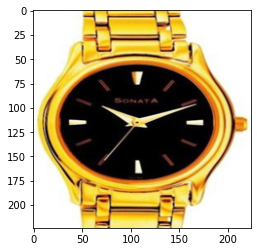

In [ ]:
idx = np.random.randint(len(X_train))
print('index of image:', idx)
cat = int(y_train[idx:idx+1].values)
print("categorie number: ", cat, "categorie name:", real_category(cat))
imgplot = plt.imshow(X_train.values[idx])
plt.show()

In [42]:
# Define the model_cv architecture
tf.random.set_seed(0)

# Créer un modèle de traitement d'images en utilisant Keras
model_cv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(18, (3,3), activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3), name="input_cv"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dense(175, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dense(110, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(len(dico_label), activation='softmax')
])

model_cv.compile(optimizer=tf.keras.optimizers.Adam(1.2e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mcp_save = tf.keras.callbacks.ModelCheckpoint('./model_cv/computer_vision_08-12-10h.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# # reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-6, mode='min')

model_cv.fit(x_train, y_train, batch_size=32, epochs=100, callbacks=[callback, mcp_save], validation_data=(x_test, y_test))
print('test set:', model_cv.evaluate(x_test, y_test))

Epoch 1/100
27/27 [==============================] - 4s 127ms/step - loss: 1.9526 - accuracy: 0.1726 - val_loss: 1.9164 - val_accuracy: 0.3090
Epoch 2/100
27/27 [==============================] - 3s 94ms/step - loss: 1.8623 - accuracy: 0.3250 - val_loss: 1.8083 - val_accuracy: 0.3483
Epoch 3/100
27/27 [==============================] - 3s 99ms/step - loss: 1.7184 - accuracy: 0.3940 - val_loss: 1.6912 - val_accuracy: 0.3708
Epoch 4/100
27/27 [==============================] - 2s 89ms/step - loss: 1.5716 - accuracy: 0.4238 - val_loss: 1.5702 - val_accuracy: 0.4101
Epoch 5/100
27/27 [==============================] - 2s 91ms/step - loss: 1.4184 - accuracy: 0.4786 - val_loss: 1.4610 - val_accuracy: 0.4663
Epoch 6/100
27/27 [==============================] - 2s 89ms/step - loss: 1.2632 - accuracy: 0.5774 - val_loss: 1.4179 - val_accuracy: 0.5000
Epoch 7/100
27/27 [==============================] - 2s 91ms/step - loss: 1.1597 - accuracy: 0.6155 - val_loss: 1.3045 - val_accuracy: 0.5787
Epoch

In [43]:
print('validation set:', model_cv.evaluate(x_val, y_val))

1/1 [==============================] - 0s 54ms/step - loss: 1.3349 - accuracy: 0.5938
validation set: [1.3349316120147705, 0.59375]


index de l'image du jeu de validation: 30 pour la catégorie: [4]


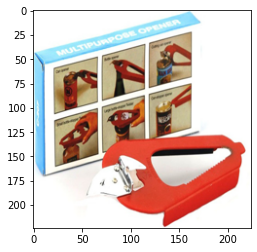

1/1 [==============================] - 0s 17ms/step
Result prediction:  home furnishing  // --> with probability of: 0.23787841
Real category is:  kitchen & dining


In [ ]:
idx = np.random.randint(0,len(x_val))
img_category = y_val[idx:idx+1].values
real_cat = str(real_category(int(img_category)))
print("index de l'image du jeu de validation:", idx, "pour la catégorie:", img_category)
imgplot = plt.imshow(x_val[idx])
plt.show()

idx_result = np.argmax(model_cv.predict(x_val[idx:idx+1])[0])
good_prediction = False
for key, val in dico_label.items():
  if val == idx_result:
    print("Result prediction: ", key, " // --> with probability of:", model_cv.predict(x_val[idx:idx+1])[0][idx_result])
print('Real category is: ', real_cat)

In [ ]:
model_cv.evaluate(x_val, y_val)

1/1 [==============================] - 0s 87ms/step - loss: 1.0015 - accuracy: 0.6875


[1.0014982223510742, 0.6875]

# Model NLP

In [39]:
# Séparer les données en ensemble d'entraînement et de test
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(df["description"], df["categories"], test_size=0.2, random_state=2)
X_test_nlp, X_val_nlp, y_test_nlp, y_val_nlp = train_test_split(X_test_nlp, y_test_nlp, test_size=0.15, shuffle=True, random_state=2)
print(X_train_nlp.shape, X_test_nlp.shape, y_train_nlp.shape, y_test_nlp.shape, X_val_nlp.shape, y_val_nlp.shape)
# Encoder les données de catégorie en entiers
label_encoder = LabelEncoder()
y_train_nlp = label_encoder.fit_transform(y_train_nlp)
y_test_nlp = label_encoder.transform(y_test_nlp)
y_val_nlp = label_encoder.transform(y_val_nlp)

(840,) (178,) (840,) (178,) (32,) (32,)


In [40]:
# Créer un tokenizer pour convertir les mots en tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_nlp)

# Convertir les données d'entraînement et de test en séquences de tokens
X_train_tokens = tokenizer.texts_to_sequences(X_train_nlp)
X_test_tokens = tokenizer.texts_to_sequences(X_test_nlp)
X_val_tokens = tokenizer.texts_to_sequences(X_val_nlp)

In [41]:
# Définissez un lemmatizer pour lemmatiser et stemmer les tokens
lemmatizer = WordNetLemmatizer()

# Lemmatisez et stemmez les tokens pour chaque séquence dans l'ensemble d'entraînement et de test
X_train_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_train_tokens]
X_test_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_test_tokens]
X_val_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_val_tokens]

# Pad les séquences pour avoir la même longueur
max_length = max([len(x) for x in X_train_lemmatized + X_test_lemmatized])
X_train_padded = pad_sequences(X_train_lemmatized, maxlen=max_length)
X_test_padded = pad_sequences(X_test_lemmatized, maxlen=max_length)
X_val_padded = pad_sequences(X_val_lemmatized, maxlen=max_length)

In [28]:
# Créer le modèle en utilisant Keras
model_nlp = Sequential()
model_nlp.add(Embedding(len(tokenizer.word_index) + 1, 300, input_length=max_length, name="input_nlp"))
model_nlp.add(LSTM(100, return_sequences=True))
model_nlp.add(LSTM(100))
model_nlp.add(Dense(100, activation="relu"))
model_nlp.add(Dense(len(label_encoder.classes_), activation="softmax"))


# Compiler le modèle en utilisant la fonction de coût sparse_categorical_crossentropy et l'optimiseur Adam
model_nlp.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Définissez l'objet EarlyStopping en spécifiant la métrique à surveiller et le nombre de périodes à surveiller sans amélioration
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mcp_save = tf.keras.callbacks.ModelCheckpoint('./model_cv/nlp_08-12-22-9h30.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# # reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-6, mode='min')

# Entraîner le modèle en utilisant l'ensemble d'entraînement et la validation croisée
model_nlp.fit(X_train_padded, y_train_nlp, validation_data=(X_test_padded, y_test_nlp), epochs=20, callbacks=[callback, mcp_save])

Epoch 1/20
27/27 [==============================] - 5s 92ms/step - loss: 1.7125 - accuracy: 0.3583 - val_loss: 1.2708 - val_accuracy: 0.4775
Epoch 2/20
27/27 [==============================] - 2s 60ms/step - loss: 0.8354 - accuracy: 0.6845 - val_loss: 0.7561 - val_accuracy: 0.7079
Epoch 3/20
27/27 [==============================] - 2s 58ms/step - loss: 0.3995 - accuracy: 0.8786 - val_loss: 0.7300 - val_accuracy: 0.7584
Epoch 4/20
27/27 [==============================] - 2s 60ms/step - loss: 0.2133 - accuracy: 0.9357 - val_loss: 0.6663 - val_accuracy: 0.7865
Epoch 5/20
27/27 [==============================] - 2s 68ms/step - loss: 0.1674 - accuracy: 0.9524 - val_loss: 0.7272 - val_accuracy: 0.8146
Epoch 6/20
27/27 [==============================] - 2s 66ms/step - loss: 0.0725 - accuracy: 0.9786 - val_loss: 0.7407 - val_accuracy: 0.8034
Epoch 7/20
27/27 [==============================] - 2s 92ms/step - loss: 0.0453 - accuracy: 0.9857 - val_loss: 0.7979 - val_accuracy: 0.8146
Epoch 8/20
27

In [29]:
# Évaluer la performance du modèle en utilisant l'ensemble de test
score, accuracy = model_nlp.evaluate(X_test_padded, y_test_nlp, verbose=0)
print("Test score: ", score)
print("Test accuracy: ", accuracy)

Test score:  0.6663440465927124
Test accuracy:  0.7865168452262878


In [42]:
score, accuracy = model_nlp.evaluate(X_val_padded, y_val_nlp, verbose=0)
print("Test score: ", score)
print("Test accuracy: ", accuracy)

Test score:  0.7265390157699585
Test accuracy:  0.84375


# Concat NLP and CV models

In [ ]:
def real_category(idx):
  for key, val in dico_label.items():
    if idx == val:
      return key 

In [ ]:
# A vérifier (fait sans pouvoir run)

X_train, X_test, y_train, y_test = train_test_split(df[['images_vector','description']], df.categories, test_size=0.2, shuffle=True, random_state=2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.15, shuffle=True, random_state=2)

X_train_cv = np.array([np.array(val) for val in X_train['images_vector']])
X_test_cv = np.array([np.array(val) for val in X_test['images_vector']])
X_val_cv = np.array([np.array(val) for val in X_val['images_vector']])

X_train_nlp = X_train['description']
X_test_nlp = X_test['description']
X_val_nlp = X_val['description']

print(X_train_cv.shape, X_test_cv.shape, X_val_cv.shape)
print(X_train_nlp.shape, X_test_nlp.shape, X_val_nlp.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(840, 224, 224, 3) (178, 224, 224, 3) (32, 224, 224, 3)
(840,) (178,) (32,)
(840,) (178,) (32,)


In [ ]:
# Créer un tokenizer pour convertir les mots en tokens
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_nlp)

# Convertir les données d'entraînement et de test en séquences de tokens
X_train_tokens = tokenizer.texts_to_sequences(X_train_nlp)
X_test_tokens = tokenizer.texts_to_sequences(X_test_nlp)
X_val_tokens = tokenizer.texts_to_sequences(X_val_nlp)

# Définissez un lemmatizer pour lemmatiser et stemmer les tokens
lemmatizer = WordNetLemmatizer()

# Lemmatisez et stemmez les tokens pour chaque séquence dans l'ensemble d'entraînement et de test
X_train_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_train_tokens]
X_test_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_test_tokens]
X_val_lemmatized = [[lemmatizer.lemmatize(str(token)) for token in sequence] for sequence in X_val_tokens]

# Pad les séquences pour avoir la même longueur
max_length = max([len(x) for x in X_train_lemmatized + X_test_lemmatized])
X_train_padded = pad_sequences(X_train_lemmatized, maxlen=max_length)
X_test_padded = pad_sequences(X_test_lemmatized, maxlen=max_length)
X_val_padded = pad_sequences(X_val_lemmatized, maxlen=max_length)

In [ ]:
# Créer le modèle en utilisant Keras
model_nlp = Sequential()
model_nlp.add(Embedding(len(tokenizer.word_index) + 1, 300, input_length=max_length, name="input_nlp"))
model_nlp.add(LSTM(100, return_sequences=True))
model_nlp.add(LSTM(100))
model_nlp.add(Dense(100, activation="relu"))

# Récupérer les entrées et les sorties du modèle de traitement du langage naturel
inputs_nlp = model_nlp.input
outputs_nlp = model_nlp.output

# Créer un modèle de traitement d'images en utilisant Keras
model_cv = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(18, (3,3), activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE,3), name="input_cv"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(102, activation='relu'),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.04),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.08),
])

# Récupérer les entrées et les sorties du modèle d'images
inputs_cv = model_cv.input
outputs_cv = model_cv.output

# Fusionner les sorties des deux modèles en une seule sortie
merged_outputs = tf.keras.layers.concatenate([outputs_nlp, outputs_cv], name="output_final")

# Ajouter une dernière couche dense pour la classification
output_layer = Dense(7, activation="softmax")(merged_outputs)

# Créer un modèle fonctionnel à partir des entrées et de la sortie finale
functional_model = Model(inputs=[inputs_nlp, inputs_cv], outputs=output_layer) 

functional_model.compile(optimizer=tf.keras.optimizers.Adam(1.2e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mcp_save = tf.keras.callbacks.ModelCheckpoint('./model_cv/multi_input_84.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_delta=1e-6, mode='min')

functional_model.fit([X_train_padded, X_train_cv], y_train, batch_size=32, epochs=100, callbacks=[callback, mcp_save], validation_data=([X_test_padded, X_test_cv], y_test))

# functional_model.evaluate(x_test, y_test)

Epoch 1/100
27/27 [==============================] - 32s 1s/step - loss: 11.0746 - accuracy: 0.2595 - val_loss: 1.9115 - val_accuracy: 0.1573
Epoch 2/100
27/27 [==============================] - 17s 659ms/step - loss: 1.5429 - accuracy: 0.4738 - val_loss: 1.8439 - val_accuracy: 0.3371
Epoch 3/100
27/27 [==============================] - 17s 641ms/step - loss: 1.1884 - accuracy: 0.5750 - val_loss: 1.8021 - val_accuracy: 0.3989
Epoch 4/100
27/27 [==============================] - 17s 636ms/step - loss: 0.8762 - accuracy: 0.7036 - val_loss: 1.7151 - val_accuracy: 0.3146
Epoch 5/100
27/27 [==============================] - 17s 645ms/step - loss: 0.5771 - accuracy: 0.7929 - val_loss: 1.4075 - val_accuracy: 0.5169
Epoch 6/100
27/27 [==============================] - 17s 636ms/step - loss: 0.3158 - accuracy: 0.8988 - val_loss: 1.3076 - val_accuracy: 0.5225
Epoch 7/100
27/27 [==============================] - 17s 647ms/step - loss: 0.2089 - accuracy: 0.9357 - val_loss: 1.2199 - val_accuracy: 0

In [ ]:
functional_model.evaluate([X_val_padded, X_val_cv], y_val)

1/1 [==============================] - 0s 171ms/step - loss: 0.4444 - accuracy: 0.8438


[0.44440004229545593, 0.84375]

In [ ]:
idx=1
functional_model.predict([X_val_padded[idx:idx+1] , X_val_cv[idx:idx+1]])[0]

1/1 [==============================] - 0s 78ms/step


array([3.0650015e-03, 6.4111367e-04, 1.3726825e-02, 1.5783751e-01,
       8.1864315e-01, 4.0288684e-03, 2.0574641e-03], dtype=float32)

index de l'image du jeu de validation: 16 pour la catégorie: [6]


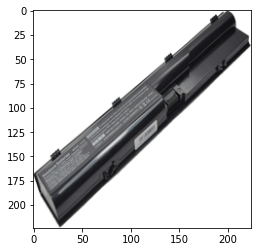

1/1 [==============================] - 0s 50ms/step
Result prediction:  computers  // --> with probability of: 0.9518556
Real category is:  computers


In [ ]:
idx = np.random.randint(0,len(x_val))
img_category = y_val[idx:idx+1].values
real_cat = str(real_category(int(img_category)))
print("index de l'image du jeu de validation:", idx, "pour la catégorie:", img_category)
imgplot = plt.imshow(x_val[idx])
plt.show()

idx_result = np.argmax(functional_model.predict([X_val_padded[idx:idx+1] , X_val_cv[idx:idx+1]])[0])
good_prediction = False
for key, val in dico_label.items():
  if val == idx_result:
    print("Result prediction: ", key, " // --> with probability of:", max(functional_model.predict([X_val_padded[idx:idx+1] , X_val_cv[idx:idx+1]])[0]) )
print('Real category is: ', real_cat)